In [1]:
%pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [2]:
# import desired packages
import tensorflow_addons as tfa
import pandas as pd
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [3]:
# Access the Google Drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set the input parameters
experimentNum = 26
filePath = '/content/drive/MyDrive/03_10_Stock_Price_Prediction/DATASET/amd_1year.csv'
# filePath = 'amd_1year.csv'
inputFeatureList = ['open', 'high', 'low', 'close', 'volume', 'V1', 'V2', 'V3']
(prevMin, predMin) = (120, 60)
batch_size = 32
epochs = 20
diffClose = 1

In [5]:
# Load the dataset
df = pd.read_csv(filePath)

In [6]:
# Rename the columns into sample format
df = df.rename(columns={'t': 'time stamp', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'})
df.columns

Index(['symbol', 'time stamp', 'open', 'high', 'low', 'close', 'volume', 'vw',
       'V1', 'V2', 'V3'],
      dtype='object')

In [7]:
# Print the columns of the dataframe
df.columns

Index(['symbol', 'time stamp', 'open', 'high', 'low', 'close', 'volume', 'vw',
       'V1', 'V2', 'V3'],
      dtype='object')

In [8]:
# Get the desired columns in the dataframe
df = df[['time stamp', 'open', 'high', 'low', 'close', 'volume', 'V1', 'V2', 'V3']]
df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', \
                                           'close']].round(decimals=4)
df['time stamp'] = pd.to_datetime(df['time stamp'])
df.head(10)

<ipython-input-8-f71b9dbb4fc6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', \


,time stamp,open,high,low,close,volume,V1,V2,V3
0,2022-03-22 04:01:00,115.75,115.75,115.75,115.75,318,0.00,0.00,0.0
1,2022-03-22 04:04:00,115.89,115.90,115.89,115.90,482,0.01,0.01,0.0
2,2022-03-22 04:05:00,115.99,115.99,115.99,115.99,664,0.00,0.00,0.0
3,2022-03-22 04:08:00,116.30,116.30,116.26,116.26,3462,0.04,-0.04,0.0
4,2022-03-22 04:09:00,116.26,116.35,116.26,116.32,1571,0.09,0.06,0.0
5,2022-03-22 04:10:00,116.35,116.40,116.30,116.40,7401,0.10,0.05,0.0
6,2022-03-22 04:11:00,116.35,116.35,116.35,116.35,493,0.00,0.00,0.0
7,2022-03-22 04:15:00,116.48,116.48,116.48,116.48,673,0.00,0.00,0.0
8,2022-03-22 04:16:00,116.46,116.46,116.46,116.46,754,0.00,0.00,0.0
9,2022-03-22 04:19:00,116.47,116.47,116.47,116.47,133,0.00,0.00,0.0


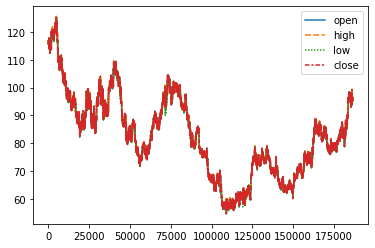

In [9]:
# Display the stock of open, high, low, close
sb.lineplot(data = df[['open', 'high', 'low', 'close']])
plt.show()

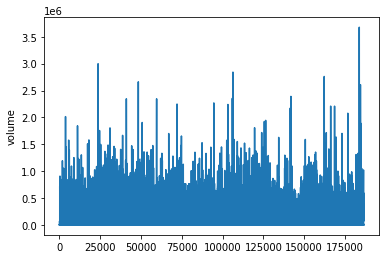

In [10]:
# Display the stock of volume
sb.lineplot(data = df['volume'])
plt.show()

In [11]:
# Show the statistics of the data
df.describe()

,open,high,low,close,volume,V1,V2,V3
count,186512.000000,186512.000000,186512.000000,186512.000000,1.865120e+05,186512.000000,186512.000000,1.865120e+05
mean,82.517099,82.573712,82.460352,82.516768,1.079922e+05,0.113360,-0.000331,-2.718285e+04
std,14.681847,14.691591,14.671496,14.681501,1.473396e+05,0.144418,0.106110,1.859003e+05
min,54.613800,54.925000,54.570000,54.615000,1.000000e+02,0.000000,-5.610000,-1.396814e+06
25%,71.502875,71.540000,71.471325,71.503750,1.403000e+03,0.020000,-0.034300,-1.179404e+05
50%,82.200000,82.250000,82.160100,82.200000,5.732750e+04,0.085000,0.000000,-1.025750e+03
75%,93.489925,93.540000,93.400000,93.483350,1.682345e+05,0.150000,0.030200,5.436538e+04
max,125.519900,125.670000,125.210000,125.515000,3.677038e+06,6.280000,3.223800,3.324818e+06


In [12]:
# Split the dataframe into training and test dataset
df_train = df[0:int(len(df) * 0.6)]
df_val = df[int(len(df) * 0.6):int(len(df) * 0.8)]
df_test = df[int(len(df) * 0.8):-1]
print(len(df_train), len(df_val), len(df_test))

111907 37302 37302


In [13]:
# Print the tail of training, validation and test datasets
print(df_train.tail())
print(df_val.tail())
print(df_test.tail())

                time stamp   open   high    low  close  volume    V1    V2  \
111902 2022-10-19 06:50:00  57.70  57.76  57.70  57.76     310  0.06  0.06   
111903 2022-10-19 07:00:00  57.88  57.89  57.87  57.89    3434  0.02  0.01   
111904 2022-10-19 07:01:00  57.89  57.89  57.86  57.87    1457  0.03 -0.02   
111905 2022-10-19 07:02:00  57.90  57.92  57.90  57.92     865  0.02  0.02   
111906 2022-10-19 07:05:00  57.97  57.97  57.97  57.97    1360  0.00  0.00   

              V3  
111902 -399544.3  
111903 -375867.0  
111904 -361695.4  
111905 -361307.5  
111906 -366006.7  
                time stamp    open    high      low    close  volume      V1  \
149204 2023-01-05 12:03:00  63.420  63.425  63.3645  63.4000   66752  0.0605   
149205 2023-01-05 12:04:00  63.400  63.420  63.3700  63.3799   50165  0.0500   
149206 2023-01-05 12:05:00  63.365  63.375  63.3300  63.3550   46446  0.0450   
149207 2023-01-05 12:06:00  63.360  63.490  63.3500  63.4300   85107  0.1400   
149208 2023-01-05

In [14]:
# Normalize the dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
training = scaler.fit_transform(df_train[inputFeatureList])
validation = scaler.transform(df_val[inputFeatureList])
test = scaler.transform(df_test[inputFeatureList])

In [15]:
# Save the Scaler
import joblib
scaler_filename = '/content/drive/MyDrive/03_10_Stock_Price_Prediction/RESULT/scaler_amd1_year_03_27' + \
          str(experimentNum) + '.save'
# scaler_filename = str(experimentNum) + '.save'
joblib.dump(scaler, scaler_filename)

['/content/drive/MyDrive/03_10_Stock_Price_Prediction/RESULT/scaler_amd1_year_03_2726.save']

In [16]:
print(training.shape, validation.shape, test.shape)

(111907, 8) (37302, 8) (37302, 8)


In [17]:
"""Define the function to create 
the input and output dataset for the training, validation and test"""
def create_dataset(transformed, df, prevMin, predMin):

    # Initialize the lists
    Xs, ys = [], []
    diffCloseList = [0.5, 0.5, 1]
    windowList = [15, 30, 60]

    # Iterate all the values in the dataframe
    for i in range(len(transformed) - prevMin - predMin):
        vx, vy = [], []

        # Append all the x items into vx
        for j in range(prevMin):
            vx.append(transformed[i + j])
        
        # Calculate the difference of closes between 15min, 30min, 45min, 60min and append items into vy
        for j in range(3):
            # window = 15 * (j + 1)
            window = windowList[j]
            diff = df['close'].iloc[i + window] - df['close'].iloc[i]
            if diff > diffCloseList[j]:
                vy.append(2)
            elif diff < -diffCloseList[j]:
                vy.append(0)
            else:
                vy.append(1)

        # Convert vx, vy into numpy arrays
        vx = np.array(vx)
        vy = np.array(vy)
        vx = vx.reshape(-1, 1)
        vy = vy.reshape(-1, 1)
        Xs.append(vx)
        ys.append(vy)
    return np.array(Xs), np.array(ys)

In [18]:
# Create the input and output of the models; prevMin=120m, predMin=[15, 30, 60]
train_X, train_y = create_dataset(training, df_train, prevMin, predMin)
val_X, val_y = create_dataset(validation, df_val, prevMin, predMin)
test_X, test_y = create_dataset(test, df_test, prevMin, predMin)

In [19]:
train_y.shape

(111727, 3, 1)

In [20]:
df_train.shape, df_val.shape, df_test.shape

((111907, 9), (37302, 9), (37302, 9))

In [21]:
sum(train_y == 2), sum(train_y == 1), sum(train_y == 0)

(array([[ 8794],
        [15186],
        [ 9668]]), array([[93211],
        [79993],
        [90481]]), array([[ 9722],
        [16548],
        [11578]]))

In [22]:
from keras.utils import to_categorical
train_labels = to_categorical(train_y)
val_labels = to_categorical(val_y)
test_labels = to_categorical(test_y)

In [23]:
print('Number of increase: ', sum(train_labels[:, 2] == 1))
print('Number of decrease: ', sum(train_labels[:, 0] == 1))
print('Number of const', sum(train_labels[:, 1] == 1))

Number of increase:  [11578 90481  9668]
Number of decrease:  [ 9722 93211  8794]
Number of const [16548 79993 15186]


In [24]:
print(train_X.shape, train_labels.shape)
print(val_X.shape, val_labels.shape)
print(test_X.shape, test_labels.shape)

(111727, 960, 1) (111727, 3, 3)
(37122, 960, 1) (37122, 3, 3)
(37122, 960, 1) (37122, 3, 3)


In [25]:
# Define the callback
callback = EarlyStopping(monitor='loss', patience=3)
f1 = tfa.metrics.F1Score(num_classes=3, average=None)

In [26]:
class MultipleOutputModel():
    """Used to generate multi-output model"""

    def make_default_hidden_layers(self, inputs):
        """Used to generate a default set of hidden layers"""
        x = LSTM(units=100, return_sequences=True)(inputs)
        x = Dropout(0.2)(x)
        x = LSTM(units=50, return_sequences=True)(x)
        x = Dropout(0.2)(x)
        return x
    
    def build_branch1(self, inputs):
        """Used to build the branch layers"""
        x = self.make_default_hidden_layers(inputs)
        
        x = Flatten()(x)
        x = Dense(20, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(3, activation='softmax', name='branch1_output')(x)
        return x
    
    def build_branch2(self, inputs):
        """Used to build the branch layers"""
        x = self.make_default_hidden_layers(inputs)
        
        x = Flatten()(x)
        x = Dense(20, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(3, activation='softmax', name='branch2_output')(x)
        return x

    def build_branch3(self, inputs):
        """Used to build the branch layers"""
        x = self.make_default_hidden_layers(inputs)
        
        x = Flatten()(x)
        x = Dense(20, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(3, activation='softmax', name='branch3_output')(x)
        return x

    # def build_branch4(self, inputs):
    #     """Used to build the branch layers"""
    #     x = self.make_default_hidden_layers(inputs)
        
    #     x = Flatten()(x)
    #     x = Dense(20, activation='relu')(x)
    #     x = BatchNormalization()(x)
    #     x = Dense(3, activation='softmax', name='branch4_output')(x)
    #     return x
    
    def assemble_full_model(self, input_shape):
        """Used to assemble all the branches to build the whole model"""
        # input_shape = train_X.shape[1]
        inputs = Input(shape=input_shape)
        branchList = []
        branch1 = self.build_branch1(inputs)
        branch2 = self.build_branch2(inputs)
        branch3 = self.build_branch3(inputs)
        # branch4 = self.build_branch4(inputs)
        model = Model(inputs=inputs, outputs=[branch1, branch2, branch3])
        return model

model = MultipleOutputModel().assemble_full_model(input_shape=(train_X.shape[1], 1))
model.compile(optimizer='adam', loss={'branch1_output': 'categorical_crossentropy', 
                                      'branch2_output': 'categorical_crossentropy',
                                      'branch3_output': 'categorical_crossentropy'}, \
                                metrics={
                                    'branch1_output': ['accuracy', 'Precision', 'Recall', 'AUC'],
                                    'branch2_output': ['accuracy', 'Precision', 'Recall', 'AUC'],
                                    'branch3_output': ['accuracy', 'Precision', 'Recall', 'AUC']
})

In [ ]:
#Train the model
history = model.fit(train_X, [train_labels[:, 0, :], train_labels[:, 1, :], train_labels[:, 2, :]],\
                    epochs=epochs, batch_size=batch_size, \
                    validation_data=(val_X, [val_labels[:, 0, :], val_labels[:, 1, :], val_labels[:, 2, :]]), callbacks=[callback])

Epoch 1/20
 119/3492 [>.............................] - ETA: 9:27 - loss: 2.7739 - branch1_output_loss: 0.8748 - branch2_output_loss: 0.9938 - branch3_output_loss: 0.9053 - branch1_output_accuracy: 0.7282 - branch1_output_precision: 0.8380 - branch1_output_recall: 0.3451 - branch1_output_auc: 0.8422 - branch2_output_accuracy: 0.5748 - branch2_output_precision_1: 0.6898 - branch2_output_recall_1: 0.1928 - branch2_output_auc_1: 0.7191 - branch3_output_accuracy: 0.6610 - branch3_output_precision_2: 0.8202 - branch3_output_recall_2: 0.3629 - branch3_output_auc_2: 0.7925

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/03_10_Stock_Price_Prediction/Saved_Models/' + 'model_03_27' +\
           str(experimentNum) + '.h5')
# model.save('model_03_24' + str(experimentNum) + '.h5')
print(model.evaluate(test_X, [test_labels[:, 0, :], test_labels[:, 1, :], test_labels[:, 2, :]]))

In [ ]:
# Model Test
tmp = model.predict(test_X)
classes = []
for i in range(3):
    classes.append(i + 1)

# Define the confusion matrix visuaslization function
def show_confusion_matrix(y_true, y_pred, classes=classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='pred')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 3)), labels=classes,rotation = 90)
    plt.yticks(list(range(0, 3)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

# Iterate through all the models and show the confusion matrix
for i in range(3):
    pred_y = np.argmax(tmp[i], axis=1)
    show_confusion_matrix(test_y[:, i], pred_y)